# Segmentez des clients d'un site e-commerce
Nous sommes consultants pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne. Olist souhaite que nous fournissions à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication. </br>
L'objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles, fournir à l’équipe marketing une description actionable de notre segmentation et de sa logique sous-jacente pour une utilisation optimale, et proposer un contrat de maintenance basé sur une analyse de la stabilité des segments au cours du temps. </br>
Dans ce notebook, nous allons évaluer la stabilité de notre modèle de segmentation au cours du temps.

# Sommaire :
- **Partie 1:** <a href="#C1">Importation des données</a>
- **Partie 2:** <a href="#C2">Stabilité des Clusters</a>
    - <a href="#C3"> Evolution des clusters</a>
    - <a href="#C4">Mesure de la stabilité</a>
- **Partie 3:** <a href="#C5">Contrat de maintenance</a>

# <a name="C1">Partie 1: Importation des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from datetime import *
from dateutil.relativedelta import *

pd.set_option('display.max_columns', 100)

In [45]:
data = pd.read_csv('dataCluster.csv', sep=',',encoding='utf-8')
data.head()

,nb_orders,mean_payment_installments,mean_photos_qty,mean_payment_value,mean_review_score,mean_delivery_time,last_order_purchase_timestamp,most_frequent_product_category,geolocation_lat,geolocation_lng,RFM_R,RFM_F,RFM_M,RFM,cluster
0,1,2.0,1.0,146.87,4.0,8.0,2017-05-16 15:05:35,office_furniture,-20.509898,-47.397866,1.0,1.0,4.0,114.0,5
1,1,8.0,3.0,335.48,5.0,16.0,2018-01-12 20:48:24,housewares,-23.726853,-46.545746,3.0,1.0,5.0,315.0,0
2,1,7.0,1.0,157.73,5.0,26.0,2018-05-19 16:07:45,office_furniture,-23.527788,-46.660310,4.0,1.0,4.0,414.0,0
3,1,1.0,1.0,173.30,5.0,14.0,2018-03-13 16:06:38,office_furniture,-23.496930,-46.185352,4.0,1.0,4.0,414.0,0
4,1,8.0,1.0,252.25,5.0,11.0,2018-07-29 09:51:30,home_confort,-22.987222,-47.151073,5.0,1.0,5.0,515.0,5


# <a name="C2">Partie 2: Stabilité des clusters</a>
## <a name="C3">2.1: Evolution des clusters</a>
On va évaluer la stabilité et la composition des clusters au fil des mois. Commençons par regarder comment évolue la quantité de clients dans chaque cluster.

In [46]:
#On compte le nombre de clients par cluster chaque mois
data['Y_M'] = pd.to_datetime(data['last_order_purchase_timestamp']).dt.to_period('M')
df_periods = data.groupby(['Y_M', 'cluster'])['Y_M'].count().to_frame('count').pivot_table('count', ['Y_M'], 'cluster').fillna(0).cumsum().reset_index()
df_periods['Y_M'] = df_periods['Y_M'].astype('str')

df_periods

cluster,Y_M,0,1,2,3,4,5
0,2016-09,0.0,1.0,0.0,0.0,0.0,0.0
1,2016-10,94.0,32.0,3.0,39.0,11.0,75.0
2,2017-01,233.0,54.0,26.0,149.0,31.0,449.0
3,2017-02,621.0,101.0,48.0,413.0,73.0,1270.0
4,2017-03,1090.0,190.0,88.0,785.0,142.0,2653.0
5,2017-04,1787.0,291.0,128.0,1125.0,201.0,3611.0
6,2017-05,2437.0,347.0,211.0,1676.0,289.0,5535.0
7,2017-06,3108.0,404.0,298.0,2166.0,360.0,7122.0
8,2017-07,3914.0,479.0,400.0,2725.0,422.0,9197.0
9,2017-08,4757.0,546.0,506.0,3245.0,527.0,11530.0


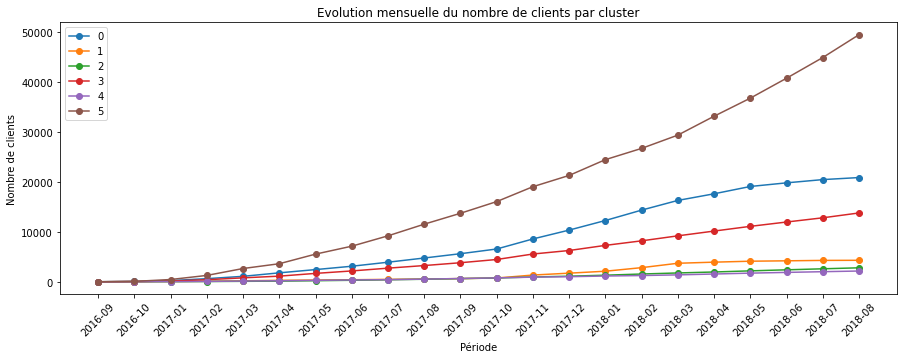

In [47]:
#On affiche l'évolution du nombre de clients par cluster
fig = plt.figure(figsize=(15,5))
ax = plt.gca()

for col in df_periods.columns[1:]:
    ax.plot(df_periods['Y_M'], df_periods[col], marker='o', label=col)

plt.xlabel('Période')
plt.xticks(rotation=45)
plt.ylabel('Nombre de clients')
plt.title('Evolution mensuelle du nombre de clients par cluster')
plt.legend()
plt.show()

La quantité de clients n'est pas complètement représentative de la stabilité des clusters. En effet, elle risque de fluctuer en fonction du développement de l'entreprise et des aléas économiques. Regardons plutôt ce que cela donne en terme de proportions.

In [48]:
#On récupère le nombre total de clients par mois
df_periods['total'] = df_periods.iloc[:,1:].sum(axis=1)
df_periods.head()

cluster,Y_M,0,1,2,3,4,5,total
0,2016-09,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2016-10,94.0,32.0,3.0,39.0,11.0,75.0,254.0
2,2017-01,233.0,54.0,26.0,149.0,31.0,449.0,942.0
3,2017-02,621.0,101.0,48.0,413.0,73.0,1270.0,2526.0
4,2017-03,1090.0,190.0,88.0,785.0,142.0,2653.0,4948.0


In [49]:
#On calcule les proportions de chaque cluster pour chaque mois
for i in range(1,7):
    df_periods.iloc[:,i] = (df_periods.iloc[:,i]/df_periods.iloc[:,7])*100
df_periods.head()

cluster,Y_M,0,1,2,3,4,5,total
0,2016-09,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,1.0
1,2016-10,37.007874,12.598425,1.181102,15.354331,4.330709,29.527559,254.0
2,2017-01,24.734607,5.732484,2.760085,15.817410,3.290870,47.664544,942.0
3,2017-02,24.584323,3.998416,1.900238,16.349960,2.889945,50.277118,2526.0
4,2017-03,22.029103,3.839935,1.778496,15.864996,2.869846,53.617623,4948.0


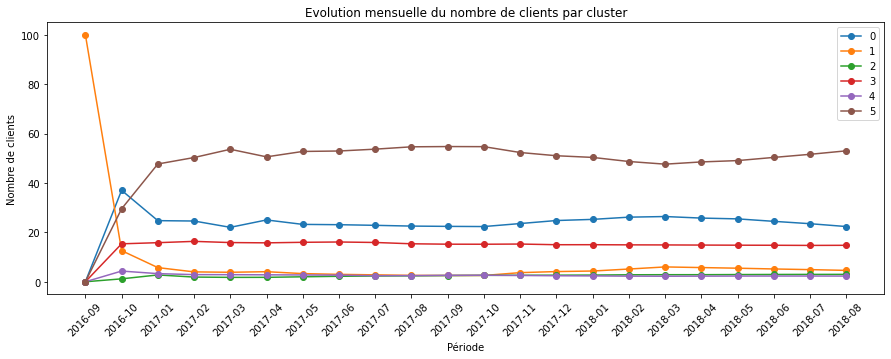

In [50]:
#On affiche l'évolution de la proportion de clients par cluster
fig = plt.figure(figsize=(15,5))
ax = plt.gca()

for col in df_periods.columns[1:7]:
    ax.plot(df_periods['Y_M'], df_periods[col], marker='o', label=col)

plt.xlabel('Période')
plt.xticks(rotation=45)
plt.ylabel('Nombre de clients')
plt.title('Evolution mensuelle du nombre de clients par cluster')
plt.legend()
plt.show()

In [51]:
df_periods.iloc[3:,1:7].mean()

cluster
0    23.986299
1     4.102132
2     2.522987
3    15.299277
4     2.503628
5    51.585677
dtype: float64

On remarque qu'une fois les premiers mois passés, nécessaires pour la constitution d'une base de données suffisante, les proportions des clusters sont très stables dans le temps, ce qui est très intéressant pour une utilisation pérenne de ces derniers.

## <a name="C4">2.2: Mesure de la stabilité</a>
Maintenant que l'on a pu visualiser l'évolution des clusters, mesurons leur stabilité un peu plus rigoureusement

In [158]:
data = pd.read_csv('dataCluster.csv', sep=',',encoding='utf-8')
data.head()

,nb_orders,mean_payment_installments,mean_photos_qty,mean_payment_value,mean_review_score,mean_delivery_time,last_order_purchase_timestamp,most_frequent_product_category,geolocation_lat,geolocation_lng,RFM_R,RFM_F,RFM_M,RFM,cluster
0,1,2.0,1.0,146.87,4.0,8.0,2017-05-16 15:05:35,office_furniture,-20.509898,-47.397866,1.0,1.0,4.0,114.0,5
1,1,8.0,3.0,335.48,5.0,16.0,2018-01-12 20:48:24,housewares,-23.726853,-46.545746,3.0,1.0,5.0,315.0,0
2,1,7.0,1.0,157.73,5.0,26.0,2018-05-19 16:07:45,office_furniture,-23.527788,-46.660310,4.0,1.0,4.0,414.0,0
3,1,1.0,1.0,173.30,5.0,14.0,2018-03-13 16:06:38,office_furniture,-23.496930,-46.185352,4.0,1.0,4.0,414.0,0
4,1,8.0,1.0,252.25,5.0,11.0,2018-07-29 09:51:30,home_confort,-22.987222,-47.151073,5.0,1.0,5.0,515.0,5


In [159]:
#On périodise le jeu de données en semaines
data['Y_W'] = pd.to_datetime(data['last_order_purchase_timestamp']).dt.to_period('W')
data.head(2)

,nb_orders,mean_payment_installments,mean_photos_qty,mean_payment_value,mean_review_score,mean_delivery_time,last_order_purchase_timestamp,most_frequent_product_category,geolocation_lat,geolocation_lng,RFM_R,RFM_F,RFM_M,RFM,cluster,Y_W
0,1,2.0,1.0,146.87,4.0,8.0,2017-05-16 15:05:35,office_furniture,-20.509898,-47.397866,1.0,1.0,4.0,114.0,5,2017-05-15/2017-05-21
1,1,8.0,3.0,335.48,5.0,16.0,2018-01-12 20:48:24,housewares,-23.726853,-46.545746,3.0,1.0,5.0,315.0,0,2018-01-08/2018-01-14


In [160]:
#On récupère les variables utilisées pour le calcul des clusters et on les trie par ordre chronologique
df = data[['nb_orders', 'mean_payment_value', 'mean_review_score', 'mean_delivery_time', 'Y_W']]
df = df.sort_values(by='Y_W', ascending=True)
df.head()

,nb_orders,mean_payment_value,mean_review_score,mean_delivery_time,Y_W
20344,1,47.82,1.0,54.0,2016-09-12/2016-09-18
6809,1,95.58,1.0,11.0,2016-10-03/2016-10-09
20722,1,111.22,5.0,8.0,2016-10-03/2016-10-09
27925,1,45.49,5.0,10.0,2016-10-03/2016-10-09
73236,1,40.95,2.0,20.0,2016-10-03/2016-10-09


La variable `Y_M` n'étant pas facile d'utilisation on va récupérer uniquement la date de fin de semaine.

In [161]:
def date_semaine(periode):
    """Fonction qui prend en entrée une période d'une semaine et renvoie la date de fin de la semaine
    au format YYYY-MM-DD"""
    date = periode.end_time.date()
    return date

In [162]:
df['Y_W'] = df['Y_W'].apply(date_semaine)
df.head()

,nb_orders,mean_payment_value,mean_review_score,mean_delivery_time,Y_W
20344,1,47.82,1.0,54.0,2016-09-18
6809,1,95.58,1.0,11.0,2016-10-09
20722,1,111.22,5.0,8.0,2016-10-09
27925,1,45.49,5.0,10.0,2016-10-09
73236,1,40.95,2.0,20.0,2016-10-09


Le jeu de données s'étalant sur presque deux ans, on va utiliser la première année pour entraîner le modèle initial et ensuite entraîner de nouveaux modèles en ajoutant à chaque fois une semaine, puis on comparera les résultats de prédiction des clusters entre le modèle initial et les nouveaux modèles.

In [163]:
#Jeu de données initial
F0 = df[df['Y_W']<date(2017, 9, 1)]
F0.tail()

,nb_orders,mean_payment_value,mean_review_score,mean_delivery_time,Y_W
27721,1,136.60,5.0,4.0,2017-08-27
86706,1,18.17,5.0,3.0,2017-08-27
3134,1,85.63,5.0,8.0,2017-08-27
89309,1,63.12,5.0,18.0,2017-08-27
54493,2,94.15,2.0,18.0,2017-08-27


In [169]:
#Création des différents jeu de données décalés à chaque fois d'une semaine
F = dict()

end = F0.iloc[-1,4]
cpt = 1
while (end < date(2018, 9, 1)):
    end = end + relativedelta(weeks=+1)
    F[cpt] = df[df['Y_W']<end]
    cpt += 1

On va à présent entraîner notre modèle initial en utilisant le jeu de données `F0`.

In [178]:
#Normalisation du jeu initial avec StandardScaler
scaler_init = StandardScaler()
F0_std = pd.DataFrame(scaler_init.fit_transform(F0.iloc[:,:-1]))

In [179]:
#Modèle initial
kmeans = KMeans(n_clusters=6, init='k-means++', n_init=10, random_state=0)
modele_init = kmeans.fit(F0_std)

A présent, on peut créer un nouveau modèle à une date T0+t et comparer avec le modèle initial de la manière suivante:
- On normalise le jeu de données correspondant à la date T0+t. On entraîne un nouveau modèle `modele_new` avec ces données. On prédit les clusters `C_new` de ces données avec le modèle `modele_new`
- On normalise le jeu de données correspondant à la date T0+t mais en utilisant le scaler `scaler_init` du modèle initial. On prédit les clusters `C_init` de ces données avec le modèle initial `modele_init`
- On calcule le score ARI des clusters `C_new` et `C_init`

In [180]:
periodes = [str(i)+' semaines' for i in range(1, len(F)+1)]
ARI = []

for i in range(1, len(F)+1):
    #Nouveau modèle
    scaler_new = StandardScaler()
    F_new_std = pd.DataFrame(scaler_new.fit_transform(F[i].iloc[:,:-1]))
    modele_new = kmeans.fit(F_new_std)
    C_new = modele_new.predict(F_new_std)
    
    #Avec l'ancien modèle
    F_new = pd.DataFrame(scaler_init.transform(F[i].iloc[:,:-1]))
    C_init = modele_init.predict(F_new)
    
    #Score ARI
    ARI.append(adjusted_rand_score(C_new, C_init))

On peut à présent regarder l'évolution du score ARI. Il est généralement pertinent de refaire un entraînement du modèle lorsque le score ARI passe en-dessous de 0.8.

In [181]:
#Tableau de comparaison des ARI
tab = np.array([ARI])
dataStabilite = pd.DataFrame(tab, index=['ARI'], columns=periodes)
dataStabilite

,1 semaines,2 semaines,3 semaines,4 semaines,5 semaines,6 semaines,7 semaines,8 semaines,9 semaines,10 semaines,11 semaines,12 semaines,13 semaines,14 semaines,15 semaines,16 semaines,17 semaines,18 semaines,19 semaines,20 semaines,21 semaines,22 semaines,23 semaines,24 semaines,25 semaines,26 semaines,27 semaines,28 semaines,29 semaines,30 semaines,31 semaines,32 semaines,33 semaines,34 semaines,35 semaines,36 semaines,37 semaines,38 semaines,39 semaines,40 semaines,41 semaines,42 semaines,43 semaines,44 semaines,45 semaines,46 semaines,47 semaines,48 semaines,49 semaines,50 semaines,51 semaines,52 semaines,53 semaines
ARI,1.0,0.995218,0.992961,0.991942,0.993177,0.977277,0.987127,0.991431,0.99098,0.982602,0.949004,0.988452,0.990656,0.97789,0.917735,0.902191,0.895302,0.889785,0.888392,0.8893,0.885753,0.883584,0.882466,0.875642,0.86629,0.856574,0.843174,0.811768,0.796761,0.77936,0.78217,0.778588,0.784486,0.796219,0.80072,0.812179,0.828012,0.838856,0.842124,0.841533,0.84486,0.852077,0.861752,0.870153,0.879329,0.887312,0.889709,0.897006,0.904834,0.913733,0.924358,0.935121,0.967755


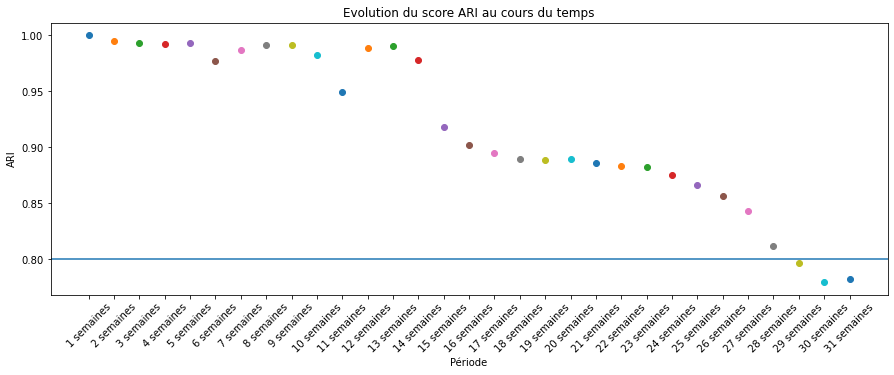

In [190]:
#On affiche l'évolution du score ARI au cours du temps
fig = plt.figure(figsize=(15,5))
ax = plt.gca()

for col in dataStabilite.columns[:31]:
    ax.plot(col, dataStabilite[col], marker='o')
    
ax.axhline(y=0.8)

plt.xlabel('Période')
plt.xticks(rotation=45)
plt.ylabel('ARI')
plt.title('Evolution du score ARI au cours du temps')
plt.show()

# <a name="C5">Partie 3: Contrat de maintenance</a>
On voit à l'aide du graphique ci-dessus que le score ARI diminue progressivement au cours des 30 premières semaines et passe en dessous de 0.8 après 28 semaines. Il serait alors souhaitable de réaliser une maintenance du modèle entre 24 et 28 semaines après son déploiement pour mettre à jour les clusters, notamment si la proportion de clients ayant effetué plusieurs commandes augmente.